# Problem Set 2

In [1]:
%%capture
# Capture suppresses output to screen
import stata_setup
stata_setup.config("/Applications/Stata 17", "be")

In [2]:
%%stata
/* Define paths for data and output */
global data "Data"
global output "Output"


. /* Define paths for data and output */
. global data "Data"

. global output "Output"

. 


In [3]:
%%capture
%%stata
log using "$output/Econ672Ps2.log", replace

## Assignment:  Econ 672 Problem Set 2
Author: Jon Holder

## Q1 - Read in Data File

In [4]:
%%stata
use "$data/econ672_njs_data.dta", clear
describe
summarize


. use "$data/econ672_njs_data.dta", clear

. describe

Contains data from Data/econ672_njs_data.dta
 Observations:        20,601                  
    Variables:            11                  22 Dec 2014 11:36
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
bifid           double  %7.0f                 
sex             byte    %8.0g      sexlbl     
age             byte    %4.0f                 
race            byte    %8.0g      raclbl     
esum18i         float   %9.0g                 
bfyrearn        float   %9.0g                 
ra_stat         byte    %8.0g      raslbl     
bfeduca         byte    %8.0g                 
totch18         byte    %8.0g                 
site_num        byte    %8.0g      sitlbl     
enroll          float   %9.0g                 
---------

## Q2 - Create *treatment* variable

In [5]:
%%stata
/* Create treatment =1 if in treatment group */
generate treatment =(ra_stat==1)
label variable treatment "=1 if in treatment group"

/* Drop observations that have missing earnings */
drop if esum18i <= 0

/* Drop treatment observations that were in control and not in JTPA */
drop if (enroll==0 & treatment==1)


. /* Create treatment =1 if in treatment group */
. generate treatment =(ra_stat==1)

. label variable treatment "=1 if in treatment group"

. 
. /* Drop observations that have missing earnings */
. drop if esum18i <= 0
(2,476 observations deleted)

. 
. /* Drop treatment observations that were in control and not in JTPA */
. drop if (enroll==0 & treatment==1)
(4,680 observations deleted)

. 


In [6]:
%%stata
tab treatment enroll


  =1 if in |
 treatment |        enroll
     group |         0          1 |     Total
-----------+----------------------+----------
         0 |     5,596        156 |     5,752 
         1 |         0      7,693 |     7,693 
-----------+----------------------+----------
     Total |     5,596      7,849 |    13,445 


## Q3 - Create indicators key pre-experiment info is missing.

In [7]:
%%stata
generate miss_child=(totch18==0 | totch18==.)
label variable miss_child "=1 if no children <18 or data missing"

generate miss_educ=(bfeduca==0 | bfeduca==.)
label variable miss_educ "=1 if education is 0 or data missing"

generate miss_earn=(bfyrearn==0 | bfyrearn==.)
label variable miss_earn "=1 if bfearn is 0 or data missing"

/* Replace missing values in main parameters with 0 */
replace totch18=0 if miss_child==1
replace bfeduca=0 if miss_educ==1
replace bfyrearn=0 if miss_earn==1


. generate miss_child=(totch18==0 | totch18==.)

. label variable miss_child "=1 if no children <18 or data missing"

. 
. generate miss_educ=(bfeduca==0 | bfeduca==.)

. label variable miss_educ "=1 if education is 0 or data missing"

. 
. generate miss_earn=(bfyrearn==0 | bfyrearn==.)

. label variable miss_earn "=1 if bfearn is 0 or data missing"

. 
. /* Replace missing values in main parameters with 0 */
. replace totch18=0 if miss_child==1
(1,194 real changes made)

. replace bfeduca=0 if miss_educ==1
(208 real changes made)

. replace bfyrearn=0 if miss_earn==1
(2,272 real changes made)

. 


In [8]:
%%stata
misstable summarize totch18 bfeduca bfyrearn

(variables nonmissing or string)


## Q4 - Estimate OLS experimental assignment to earnings

In [9]:
%%stata
regress esum18i treatment, robust
eststo baseOls

/* Print to log file */
esttab baseOls, ar2 se obslast scalars(F) ///
    coeflabels(treatment "In treatment group")

/* Printable table for report *
esttab baseOls using $output/tableQ4.tex, ///
    replace ///
    ar2 se obslast scalars(F) ///
    oeflabels(treatment "In treatment group")


. regress esum18i treatment, robust

Linear regression                               Number of obs     =      8,991
                                                F(1, 8989)        =       0.22
                                                Prob > F          =     0.6383
                                                R-squared         =     0.0000
                                                Root MSE          =     9190.7

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |   93.15785     198.17     0.47   0.638    -295.3005    481.6162
       _cons |   11489.34   154.0876    74.56   0.000     11187.29    11791.38
------------------------------------------------------------------------------

. eststo baseOls

. 
. /* Print to log file */
. esttab

## Q5 - Estimate with OLS and covariates

In [10]:
%%stata
global covariates "sex i.race age totch18 bfeduca bfyrearn i.site_num miss_child miss_educ miss_earn"

In [11]:
%%stata
regress esum18i treatment $covariates, cluster(site_num)
eststo olsCovariates


. regress esum18i treatment $covariates, cluster(site_num)

Linear regression                               Number of obs     =      8,991
                                                F(11, 15)         =          .
                                                Prob > F          =          .
                                                R-squared         =     0.1598
                                                Root MSE          =     8436.5

                              (Std. err. adjusted for 16 clusters in site_num)
------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   treatment |   187.4787   286.6478     0.65   0.523    -423.4966    798.4539
         sex |   4265.399   245.1583    17.40   0.000     3742.856    4787.941
             |
        race |
   

---

## Difference-in-differences

## Q7 - Difference-in-Difference

Estimate difference between JTPA participation and control group.  
Control group is people not enrolled in JTPA.  
Treatment group is people enrolled in JTPA and assigned to the control group.  
Treatment is enrollment in JTPA and assigned control group.

In [17]:
%%stata
generate didTreatment=(enroll==1 & treatment==0)


. generate didTreatment=(enroll==1 & treatment==0)

. generate didTreatXenroll = enroll*didTreatment

. 


In [13]:
%%stata
generate diffEarn=esum18i-bfyrearn

(4,454 missing values generated)


In [31]:
%%stata
table didTreatment, statistic(mean diffEarn)


------------------------
             |      Mean
-------------+----------
didTreatment |          
  0          |  9047.134
  1          |  8189.514
  Total      |  9036.737
------------------------


In [29]:
%%stata
regress diffEarn didTreatment,robust


. /*       outcome */
. regress diffEarn didTreatment,robust

Linear regression                               Number of obs     =      8,991
                                                F(1, 8989)        =       1.10
                                                Prob > F          =     0.2940
                                                R-squared         =     0.0001
                                                Root MSE          =     8949.1

------------------------------------------------------------------------------
             |               Robust
    diffEarn | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
didTreatment |  -857.6207   817.1391    -1.05   0.294      -2459.4    744.1583
       _cons |   9047.134   95.01691    95.22   0.000      8860.88    9233.389
------------------------------------------------------------------------------

. 


---

## Regression Discontinuity

## Q9 - Drop Data from the control group with miss_earn==1

In [90]:
%%stata
drop if treatment==0 & miss_earn==1

(2,221 observations deleted)


## Q10 - Create rdtreat=1 for Control Group with bfyrearn<=2650

In [91]:
%%stata
generate rdtreat=(treatment==0 & bfyrearn<=2650)

## Q11 - Construct a regression discontinuity with a window of \$500 on each side

In [111]:
%%stata
global window "bfyrearn>=2150 & bfyrearn<=3150"

In [130]:
%%stata
/* 
    Calculate differences in mean for data on each side
    of the window
*/
table rdtreat if $window & treatment==0, ///
    statistic(mean esum18i) ///
    statistic(semean esum18i)
regress esum18i rdtreat if $window & ///
    treatment==0, robust


. /* 
>     Calculate differences in mean for data on each side
>     of the window
> */
. table rdtreat if $window & treatment==0, ///
>     statistic(mean esum18i) ///
>     statistic(semean esum18i)

------------------------------------------------
        |      Mean   Standard error of the mean
--------+---------------------------------------
rdtreat |                                       
  0     |  11161.82                      648.808
  1     |  11978.42                     736.4323
  Total |  11499.72                     487.1008
------------------------------------------------

. regress esum18i rdtreat if $window & ///
>     treatment==0, robust

Linear regression                               Number of obs     =        290
                                                F(1, 288)         =       0.69
                                                Prob > F          =     0.4060
                                                R-squared         =     0.0024
                


RD Plot with evenly spaced mimicking variance number of bins using spacings est
> imators.

      Cutoff c = 2650 | Left of c  Right of c        Number of obs  =        67
> 9
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |       299         380
   Eff. Number of obs |       299         380
  Order poly. fit (p) |         1           1
     BW poly. fit (h) |   500.000     500.000
 Number of bins scale |     1.000       1.000

Outcome: esum18i. Running variable: bfyrearn.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        22          17
   Average bin length |    22.727      29.412
    Median bin length |    22.727      29.412
----------------------+----------------------
    IMSE-optimal bins |         3           5
  Mimicking Var. bins |        22          17
----------------------+----------------------
Re

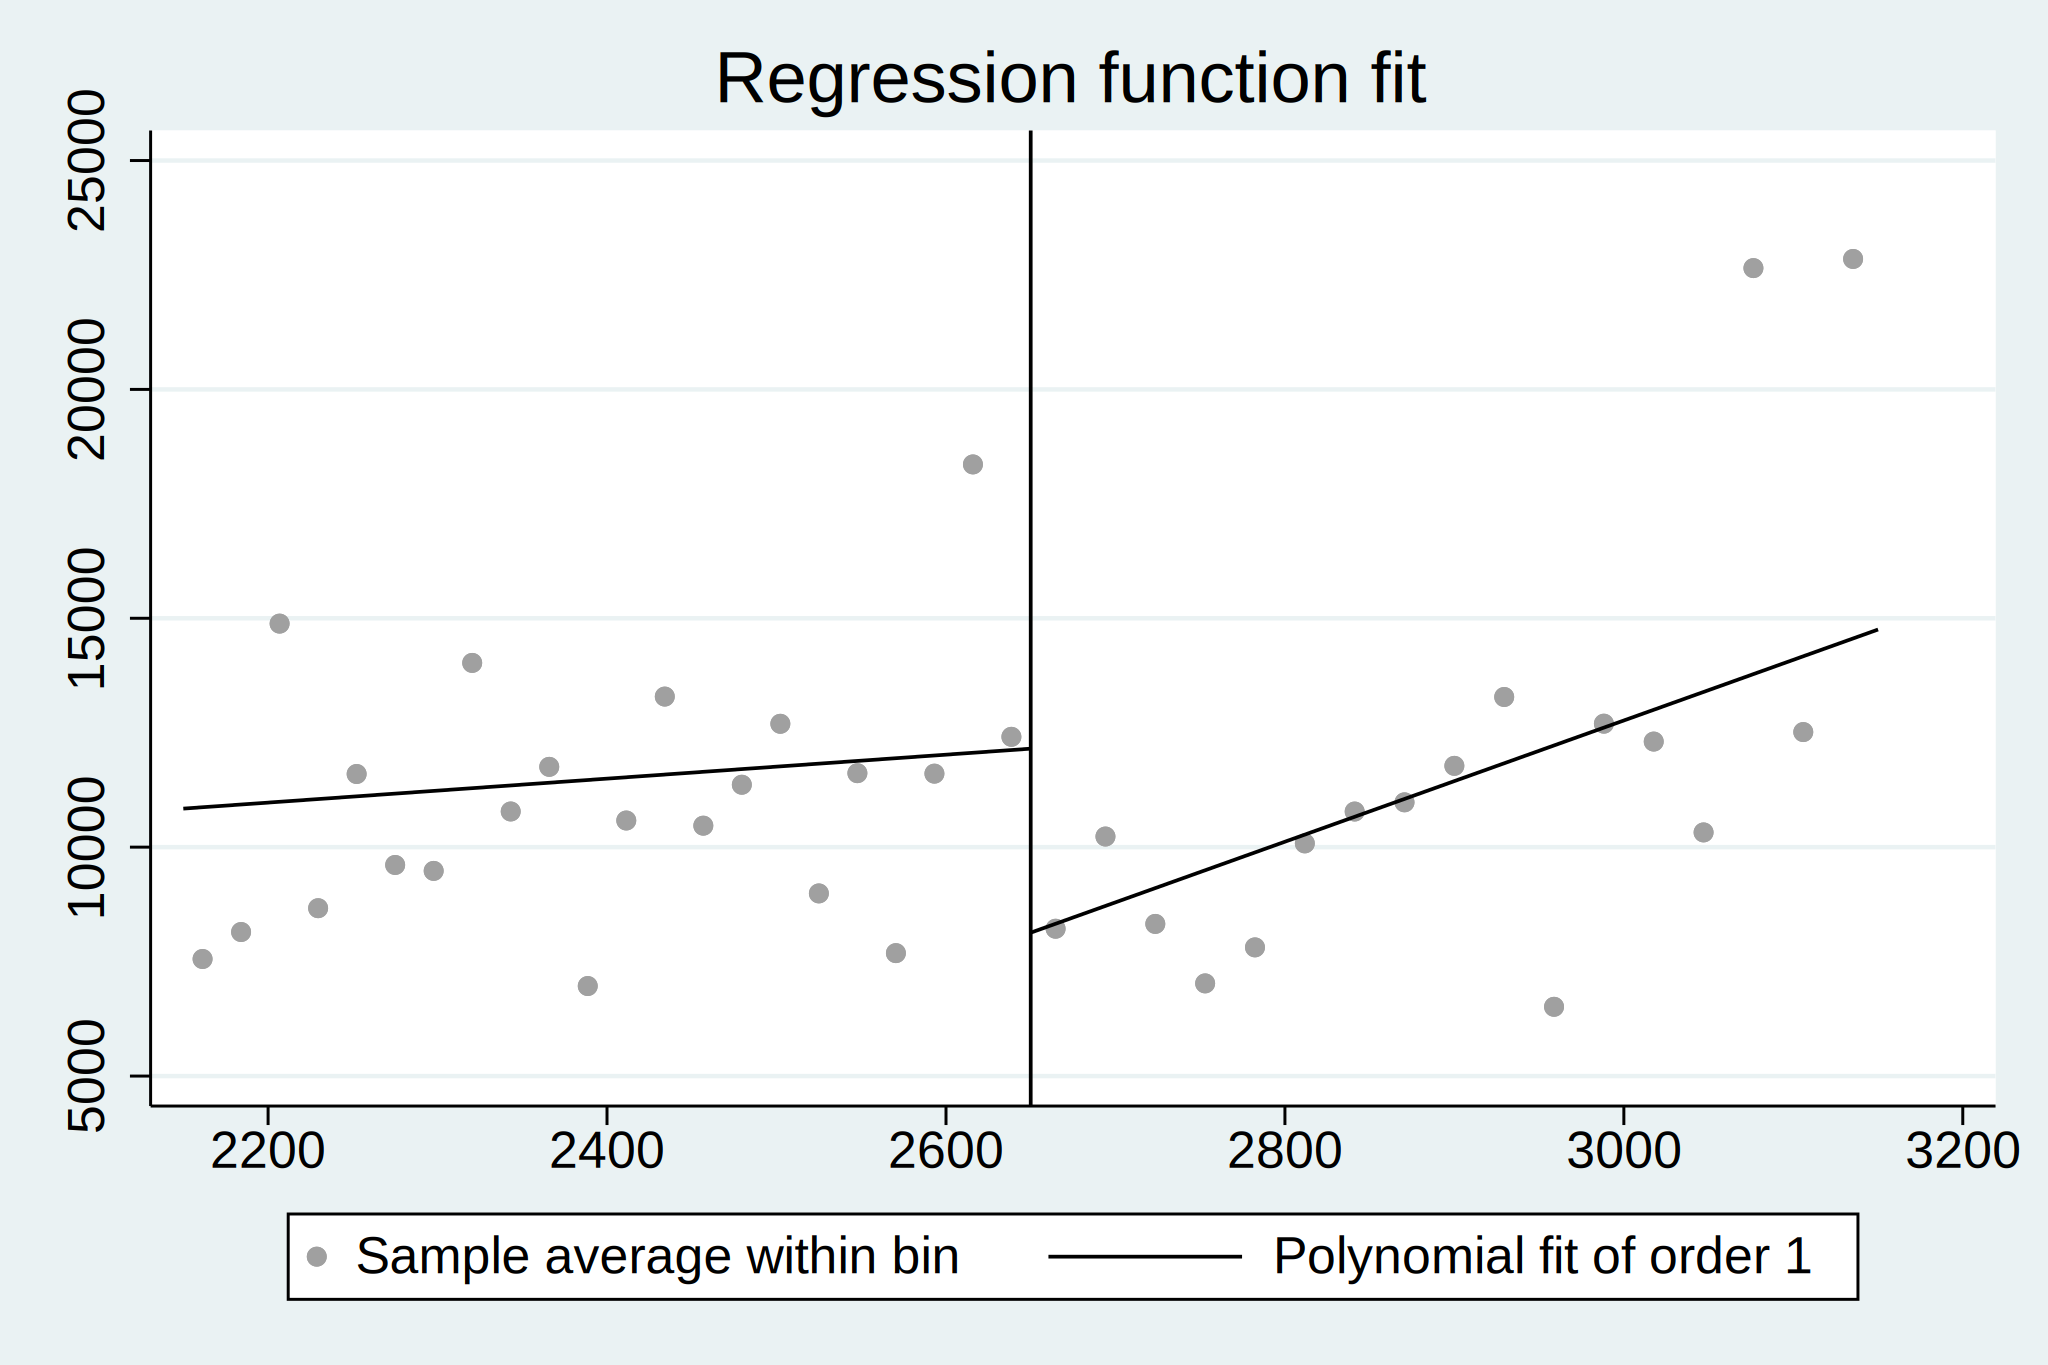

In [121]:
%%stata
rdplot esum18i bfyrearn if $window, c(2650) p(1)

## Q14 - Estimate Regression Discontinuity with OLS

In [115]:
%%stata
/* RD with all data */
regress esum18i rdtreat bfyrearn ///
    if treatment==0 ///
      , robust
eststo rdAllData


. regress esum18i rdtreat bfyrearn ///
>     if treatment==0 ///
>       , robust

Linear regression                               Number of obs     =      2,327
                                                F(2, 2324)        =      83.39
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0812
                                                Root MSE          =     9255.1

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     rdtreat |  -841.5807   552.1034    -1.52   0.128    -1924.247     241.086
    bfyrearn |   .6071539   .0794927     7.64   0.000     .4512699    .7630379
       _cons |   10367.64   564.2854    18.37   0.000      9261.09     11474.2
----------

In [117]:
%%stata
/* RD with -/+500 window */
regress esum18i rdtreat bfyrearn ///
    if treatment==0 & ///
       $window, robust
eststo rdWindow


. regress esum18i rdtreat bfyrearn ///
>     if treatment==0 & ///
>        $window, robust

Linear regression                               Number of obs     =        290
                                                F(2, 287)         =       5.65
                                                Prob > F          =     0.0039
                                                R-squared         =     0.0304
                                                Root MSE          =     8196.3

------------------------------------------------------------------------------
             |               Robust
     esum18i | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     rdtreat |   6731.868   2010.445     3.35   0.001      2774.78    10688.96
    bfyrearn |   10.97316   3.871118     2.83   0.005     3.353775    18.59254
       _cons |  -21098.81   11198.91    -1.88   0.061    -43141.22    943.5969


In [131]:
%%stata
esttab rdAllData rdWindow, ///
    ar2 se obslast ///
    mtitles("All Data" "Window")


. esttab rdAllData rdWindow, ///
>     ar2 se obslast ///
>     mtitles("All Data" "Window")

--------------------------------------------
                      (1)             (2)   
                 All Data          Window   
--------------------------------------------
rdtreat            -841.6          6731.9***
                  (552.1)        (2010.4)   

bfyrearn            0.607***        10.97** 
                 (0.0795)         (3.871)   

_cons             10367.6***     -21098.8   
                  (564.3)       (11198.9)   
--------------------------------------------
adj. R-sq           0.080           0.024   
N                    2327             290   
--------------------------------------------
Standard errors in parentheses
* p<0.05, ** p<0.01, *** p<0.001

. 
